In [1]:
import os
import json
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# 경로 설정
IMAGE_DIR = r"C:\Users\607-03\Desktop\battery3000\battery3000\images"
JSON_DIR = r"C:\Users\607-03\Desktop\battery3000\battery3000\labels"

# 클래스 정의 (0: 정상, 1: 오염, 2: 손상)
CLASS_MAP = {
    "Normal": 0,
    "Pollution": 1,
    "Damaged": 2
}

# 이미지 크기 설정
IMG_SIZE = (128, 128)

# 데이터 로드 함수
def load_data(image_dir, json_dir, max_samples=3000):
    """JSON 파일을 읽어 이미지 및 라벨 데이터를 로드하는 함수"""

    data = []
    labels = []

    json_files = [f for f in os.listdir(json_dir) if f.endswith(".json")]
    if not json_files:
        raise FileNotFoundError(f"No JSON annotation files found in {json_dir}")

    samples_count = 0

    for json_file in json_files:
        json_path = os.path.join(json_dir, json_file)
        with open(json_path, "r", encoding="utf-8") as f:
            anno = json.load(f)

        img_path = os.path.join(image_dir, anno["image_info"]["file_name"])

        # 이미지 파일 존재 여부 확인
        if not os.path.exists(img_path):
            continue

        # 이미지 로드 및 전처리
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0

        # 라벨 할당 (기본값: 정상)
        label = CLASS_MAP["Normal"]
        if "defects" in anno and anno["defects"]:
            for defect in anno["defects"]:
                defect_type = defect["name"]
                if defect_type == "Pollution":
                    label = CLASS_MAP["Pollution"]
                elif defect_type == "Damaged":
                    label = CLASS_MAP["Damaged"]
                break

        data.append(img)
        labels.append(label)

        samples_count += 1
        if samples_count >= max_samples:
            break

    return np.array(data), np.array(labels)

# 데이터 로드
X, y = load_data(IMAGE_DIR, JSON_DIR, max_samples=3000)

# 데이터 분할 (훈련 80%, 테스트 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 증강 (손상 데이터 샘플이 적기 때문에 증강 적용)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

damaged_indices = np.where(y_train == 2)[0]
for i in damaged_indices:
    img = X_train[i]
    img = img.reshape((1,) + img.shape)
    it = datagen.flow(img, batch_size=1)

    for _ in range(5):
        aug_img = next(it).reshape(X_train[i].shape)
        X_train = np.append(X_train, [aug_img], axis=0)
        y_train = np.append(y_train, [y_train[i]], axis=0)

# 라벨을 One-Hot Encoding 처리
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# 클래스 가중치 계산 (데이터 불균형 보정)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# CNN 모델 생성
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# 모델 컴파일
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 모델 학습
EPOCHS = 20
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=EPOCHS, batch_size=32, class_weight=class_weight_dict)

# 모델 저장
model.save("battery_cnn_model_final.h5")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\607-03\\Desktop\\battery3000\\battery3000\\labels'

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

📊 [정상 vs 불량 성능 평가]
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.99       186
   Defective       0.99      1.00      0.99       414

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



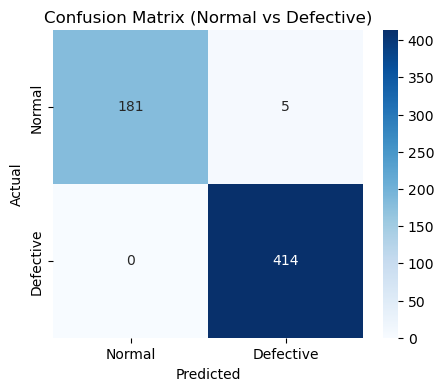


✔ 최종 정확도 (Normal vs Defective): 99.17%


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 🔹 모델 로드
model = load_model("battery_cnn_model_final.h5")

# 🔹 테스트 데이터 예측
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측된 클래스
y_true = np.argmax(y_test, axis=1)  # 실제 정답 클래스

# 🔹 "Pollution(오염) + Damaged(손상)" → 하나의 "불량" 클래스로 통합
y_true_binary = np.where(y_true == 0, 0, 1)  # 0: 정상, 1: 불량
y_pred_binary = np.where(y_pred_classes == 0, 0, 1)  # 0: 정상, 1: 불량

# 🔹 정확도, 정밀도, 재현율, F1-score 출력
print("\n📊 [정상 vs 불량 성능 평가]")
print(classification_report(y_true_binary, y_pred_binary, target_names=["Normal", "Defective"]))

# 🔹 혼동 행렬 계산 및 시각화
cm = confusion_matrix(y_true_binary, y_pred_binary)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Defective"], yticklabels=["Normal", "Defective"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Normal vs Defective)")
plt.show()

# 🔹 최종 정확도 출력
accuracy = accuracy_score(y_true_binary, y_pred_binary)
print(f"\n✔ 최종 정확도 (Normal vs Defective): {accuracy * 100:.2f}%")